# FACE RECOGNITION

#### Metode FACE RECOGNITION meliputi 4 langkah:
1. Mendeteksi dan menemukan wajah-wajah dalam sebuah image (**Face Detection**)
2. Untuk setiap gambar wajah yang ditemukan, fokus analisa apakah saat gambar wajah mengalami pergeseran orientasi atau pencahayaan yang kurang, gambar tetap mengacu pada orang yang sama
3. Menemukan fitur unik dari wajah yang bisa jadi pembeda dengan orang lain
4. Membandingkan fitur uni tersebut dengan database kumpulan fitur unik yang ada untuk melakukan pengenalan.

### I. FACE DETECTION ( DETEKSI WAJAH )

Obyektif dari ***Face Detection*** adalah menemukan region mana saja dalam gambar yang menunjukkan wajah orang. Ada beberapa metode yang digunakan untuk mencari region wajah manusia dalam gambar, antara lain :
- HAAR Classifier
> Metode ini diusulkan oleh *Paul Viola* dan *Paul Jones* dalam paper [1] tahun 2001. Terkadang disebut Viola Jones Algorithm.
- Local Binary Pattern (LBP) Classifier
> Dipopulerkan oleh Ojala dll, LBP menghitung teksture local representation dengan membandingkan setiap pixel dengan 8 pixel sekelilingnya. Jika 
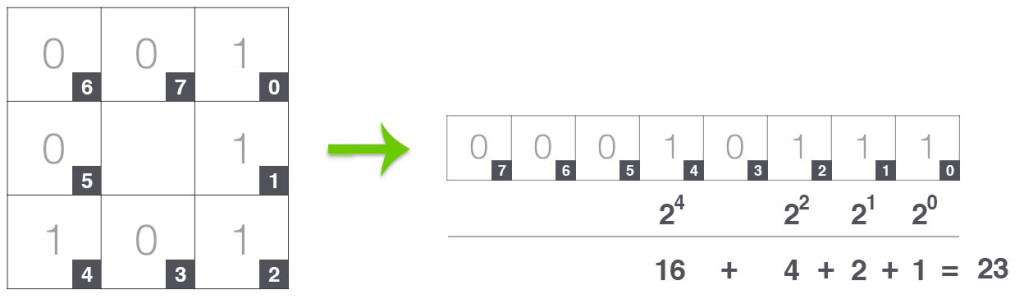
 
- Histogram of Oriented Gradient (HOG) Classifier 
> n

OpenCV library sudah mengimplementasikan ketiga metode face detection ini. Berikut adalah perbandingan performance dari Haar Classifier dan LBP Classifier yang diimplementasikan oleh library OpenCV.


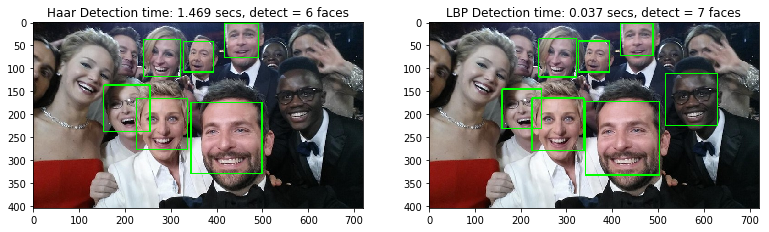

In [17]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import time

def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def detect_faces(f_cascade, colored_img, scaleFactor = 1.1):
    #just making a copy of image passed, so that passed image is not changed
    img_copy = colored_img.copy()
    
    #convert to grayscale since HAAR require greyscala image
    gray_img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

    #let's detect multiscale (some images may be closer to camera than others) images
    faces = f_cascade.detectMultiScale(gray_img, scaleFactor = scaleFactor, minNeighbors=5)
    
    #print the number of faces found
    #print('Faces found: ', len(faces))

    #go over the list of faces and draw them as rectangles on original colored img
    for (x, y, w, h) in faces:
        cv2.rectangle(img_copy, (x,y), (x+w,y+h), (0, 255, 0), 2)
    
    return len(faces), img_copy
        
#load image
test_img1 = cv2.imread('data/test2.jpg')
test_img2 = cv2.imread('data/test2.jpg')

#load cascade classifier training file for haarcascade
haar_face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_alt2.xml')
#load cascade classifier training file for lbpcascade 
lbp_face_cascade = cv2.CascadeClassifier('data/lbpcascade_frontalface.xml')  

#time before execution
t1 = time.time()
#call our function to detect faces 
haar_len, haar_faces_detected_img = detect_faces(haar_face_cascade, test_img1,scaleFactor=1.1)
#time after execution
t2 = time.time()
#time different
dt1 = t2 - t1

#time before execution
t1 = time.time()
#call our function to detect faces 
lbp_len, lbp_faces_detected_img = detect_faces(lbp_face_cascade, test_img2,scaleFactor=1.1)  
#time after execution
t2 = time.time()
#time different
dt2 = t2 - t1

#create a figure of 2 plots (one for Haar and one for LBP) 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))  
 
#show Haar image 
ax1.set_title('Haar Detection time: ' + str(round(dt1, 3)) + ' secs, detect = ' + str(haar_len) + ' faces') 
ax1.imshow(convertToRGB(haar_faces_detected_img))  
 
#show LBP image 
ax2.set_title('LBP Detection time: ' + str(round(dt2, 3)) + ' secs, detect = ' + str(lbp_len) + ' faces') 
ax2.imshow(convertToRGB(lbp_faces_detected_img))  
  
plt.show()

Dari observasi kedua metode face detection tersebut disimpulkan bahwa :
- Performance LBP lebih bagus dibanding Haar Classfier baik dalam processing time waupun jumlah wajah yang bisa dideteksi

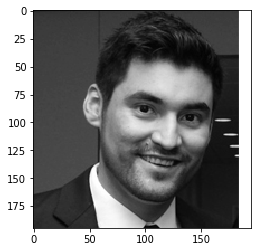

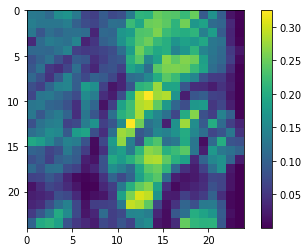

In [34]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt

test_img3 = cv2.cvtColor(cv2.imread('data/test1.jpg'), cv2.COLOR_BGR2GRAY)
cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins
# winSize is the size of the image cropped to an multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(test_img3.shape[1] // cell_size[1] * cell_size[1],
                                  test_img3.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

n_cells = (test_img3.shape[0] // cell_size[0], 
           test_img3.shape[1] // cell_size[1])
hog_feats = hog.compute(test_img3)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.

gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# count cells (border cells appear less often across overlapping groups)
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                  off_x:n_cells[1] - block_size[1] + off_x + 1] += \
            hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                   off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count
# Preview
plt.figure()
plt.imshow(test_img3, cmap='gray')
plt.show()

bin = 5  # angle is 360 / nbins * direction
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

## REFERENSI
1. Viola Paul, John Paul, ["Rapid Object Detection using a Boosted Cascade of Simple Features"](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf), 2001.
2. [Face Detection using haar cascades](https://docs.opencv.org/3.3.0/d7/d8b/tutorial_py_face_detection.html)
3. [Local Binary Pattern](http://www.scholarpedia.org/article/Local_Binary_Patterns)